In [1]:
from gurobipy import *
#from passenger import *
import pandas as pd

import matplotlib.pyplot as plt
import itertools
import random

# Data and Variables

We need to represent and access info for all passengers: gender (weight), which group they belong to, if they need to transfer quickly, etc. For this purpose we created a the class _Passenger_. We also created the class _Group_ to represent each group (numer of women, men, transit time).

In [2]:
passenger_id = 0

class Passenger:
    def __init__(self, group_index, passenger_id, description, transit_time=0):
        """
            group_index : 
            passenger_id : 
            description : men, women, wheelchair, child
            business_economic : class (Business, Economic)
            transit_time : optional parameter (inf if there is not transit time)
        
        """
        self.group_index = group_index
        self.passenger_id = passenger_id
        self.description = description
        # self.business_economic = business_economic
        self.transit_time = transit_time
        self.weight()
    
    def weight(self):
        if self.description == 'women':
            self.weight = 70
        elif self.description == 'men':
            self.weight = 85
        elif self.description == 'child':
            self.weight = 35
        else: 
            self.weight = 70 # need to check this value

class Group:

    def __init__(self, id_group, num_women, num_men, transit_time=0):
        self.id_group = id_group
        self.num_women = num_women
        self.num_men = num_men
        self.transit_time = transit_time

        self.members = []

        global passenger_id

        for i in range(self.num_women):
            self.members.append(Passenger(
                self.id_group,
                passenger_id,
                'women',
                self.transit_time
            ))
            passenger_id+=1
        
        for i in range(self.num_men):
            self.members.append(Passenger(
                self.id_group,
                passenger_id,
                'men',
                self.transit_time
            ))
            passenger_id+=1
        
        return
    
    


We then create some functions to import the data from the spreadsheets.

In [3]:
def read_and_preprocess(file, date):
    df = pd.read_excel(file, date)
    
    df['TransitTime (min)'] = df['TransitTime'].apply(lambda x: float(str(x).split(':')[0])*60+float(str(x).split(':')[1]))

    df[['Femmes', 'Hommes', 'Enfants', 'WCHR', 'WCHB']] = df[['Femmes', 'Hommes', 'Enfants', 'WCHR', 'WCHB']].fillna(0)

    return df

def get_list_passengers(df):
    list_groups = {}

    for idx, row in df.iterrows():

        list_groups[int(idx)] = Group(
            id_group=int(idx),
            num_women=int(row['Femmes']),
            num_men=int(row['Hommes']),
            transit_time=row['TransitTime (min)']
        )
    
    return list_groups


In [4]:
# Load Passengers

df = read_and_preprocess('DataSeating - V3.xlsx', '21Oct')

groups = get_list_passengers(df)

passengers = list()

for g in groups.keys():
    passengers += groups[g].members

passenger_from_id = {}
for p in passengers:
    passenger_from_id[p.passenger_id] = p

As a final setup we define some problem parameters.

In [5]:

passengers_count = len(passengers)

width = 6
height = 28
X = [-3, -2, -1, 0, 1, 2, 3]
Y = list(range(-14,0)) + list(range(1,14+1))

total_weight = sum(p.weight for p in passengers)


# Model Definition

In [6]:
m = Model("model_v1")

Set parameter Username
Academic license - for non-commercial use only - expires 2023-01-27


The main decision variable here is the allocation $A^p_{(i~,~j)}$ : binary variable that says for each passenger with id $p$ if he is located at the seat in coordinates $(i~,~j)$.


This is represented in python by the variable allocation[p, i, j].

For instance, if passenger 1 is at the place : (2, 3), then allocation[1,2,3] = 1. Else, it equals 0.

In [7]:
# Allocation Variables
allocation = m.addVars(passengers_count, width+1, height, vtype=GRB.BINARY, name="Allocation")

# Constraints

**At most 1 person per seat:** there can't be more than 1 person in each seat.

$$\sum_{p \in \text{Passengers}} A^p_{(i~,~j)} \leq 1~~\forall (i, j) \in \text{Seats}$$

In [8]:
# Make sure that there is at most one person per seat
C_limited_seat = m.addConstrs((quicksum([allocation[p.passenger_id,i,j] for p in passengers]) <= 1 for i in range(width+1) for j in range(height)))

**Every passenger is served:** every passenger should be allocated to precisely one seat.

$$\sum_{(i,j) \in \text{Seats}} A^p_{(i~,~j)} == 1~~\forall p \in \text{Passengers}$$

In [9]:
# Maker sure that everyone is seated and only in one spot
C_serve_all = m.addConstrs((quicksum([allocation[p.passenger_id,i,j] for i in range(width+1) for j in range(height) ]) == 1 for p in passengers))

**Empty Corridor**: there should be no passenger allocated to the corridor (i=3).
$$A^p_{(i,j)}==0~~\forall (p,i,j) \in \text{Passengers} \times \text{Seats}$$

In [10]:
# Make sure that the corridor is not considered as a possible seat
C_empty_corridor = m.addConstrs((0 == allocation[p,3,j] for p in range(passengers_count) for j in range(height)))

**Barycenter Constraint:** the center of mass of the passengers must reside within a limited area. For this purpose the barycenter function is divided into its X and Y coordinate and then each constraint is divided into an inferior limit and a superior limit constraint.

$$ \frac{1}{w_t}\sum_{(p,i,j) \in \text{Passengers} \times \text{Seats}} A^p_{(i,j)} \cdot w(p) \cdot X(i) \leq B_{max}^X$$

$$ \frac{1}{w_t}\sum_{(p,i,j) \in \text{Passengers} \times \text{Seats}} A^p_{(i,j)} \cdot w(p) \cdot X(i) \geq B_{min}^X$$

$$ \frac{1}{w_t}\sum_{(p,i,j) \in \text{Passengers} \times \text{Seats}} A^p_{(i,j)} \cdot w(p) \cdot Y(j) \leq B_{max}^Y$$

$$ \frac{1}{w_t}\sum_{(p,i,j) \in \text{Passengers} \times \text{Seats}} A^p_{(i,j)} \cdot w(p) \cdot Y(j) \geq B_{min}^Y$$


Where :
- $w_t$ is the total weight of all passengers.
- $w(p)$ is the weight of passenger with id $p$.
- $X(i)$ is the distance in meters at coordinate i.
- $Y(j)$ is the distance in meters at coordinate j.
- $B_{max}^X$ is the upper bound of the barycenter in the X axis.
- $B_{min}^X$ is the lower bound of the barycenter in the X axis.
- $B_{max}^Y$ is the upper bound of the barycenter in the Y axis.
- $B_{min}^Y$ is the lower bound of the barycenter in the Y axis.


In [11]:
# Center of Mass function
barycenter_X = quicksum([p.weight * allocation[p.passenger_id,i,j]*X[i] for p in passengers for i in range(width+1) for j in range(height)])/total_weight
barycenter_Y = quicksum([p.weight * allocation[p.passenger_id,i,j]*Y[j] for p in passengers for i in range(width+1) for j in range(height)])/total_weight

# Barycenter limits
bary_lim_X = 1
bary_lim_Y = 2

# Make sure that the center of mass is centralized

C_bary_X_p = m.addConstr(barycenter_X <=  bary_lim_X)
C_bary_X_m = m.addConstr(barycenter_X >= -bary_lim_X)
C_bary_Y_p = m.addConstr(barycenter_Y <=  bary_lim_Y)
C_bary_Y_m = m.addConstr(barycenter_Y >= -bary_lim_Y)

**Transit Time Constraint**: the people with a transit time inferior to 90 minutes should stay in the front.

$$ A^p_{(i,j)} \leq \epsilon(p) ~~ \forall (p,i,j) \in \text{Passengers in transit} \times \text{Columns} \times \text{Upper rows}$$

Where $\epsilon(p)$ is a new auxiliary variable that we want to minimize.

In [12]:
epsilon = m.addVars([p.passenger_id for p in passengers if p.transit_time < 90], vtype=GRB.BINARY)
m.addConstrs(allocation[p.passenger_id,i,j] <= epsilon[p.passenger_id] for i in range(width+1) for j in range(height) for p in passengers if p.transit_time < 90 and j > 13);

# Objective Function

As a precise calculation of the satisfying function leads to a combinatorial explosion, we decided to instead try to reduce the rectangle formed by the distribution of people from the same group, in this way they try to collapse to the same region of the plane.

For this we will need the following additional variables:
- $i^G_{max}$: highest $i$ coordinate between members of group $G$.
- $i^G_{min}$: lowest $i$ coordinate between members of group $G$.
- $j^G_{max}$: highest $j$ coordinate between members of group $G$.
- $j^G_{min}$: lowest $j$ coordinate between members of group $G$.
- $\Delta i^G$: $i^G_{max}-i^G_{min}$
- $\Delta j^G$: $j^G_{max}-j^G_{min}$

The first 4 variables are set by defining inequality constraints based on the coordinates of the members of a group and the 2 last variables are set by defining equality constraints. Thus, our objective function becomes.

$$ \sum_{G \in \text{Groups}} \Delta i^G + \phi \cdot \Delta j^G + \sum_{p \in G} \epsilon(p) $$

Where $\phi$ is a factor for giving priorities to grouping people in the same rows.

In [13]:
i_p = m.addVars(passengers_count, vtype=GRB.INTEGER, lb=0, ub=width, name="i_p")
j_p = m.addVars(passengers_count, vtype=GRB.INTEGER, lb=0, ub=height, name="j_p")

i_g_max = m.addVars(len(groups), vtype=GRB.INTEGER, lb=0, ub=width, name="i_g_max")
i_g_min = m.addVars(len(groups), vtype=GRB.INTEGER, lb=0, ub=width, name="i_g_min")
j_g_max = m.addVars(len(groups), vtype=GRB.INTEGER, lb=0, ub=height, name="j_g_max")
j_g_min = m.addVars(len(groups), vtype=GRB.INTEGER, lb=0, ub=height, name="j_g_min")

i_g_delta = m.addVars(len(groups), vtype=GRB.INTEGER, lb=0, ub=width, name="i_g_delta")
j_g_delta = m.addVars(len(groups), vtype=GRB.INTEGER, lb=0, ub=height, name="j_g_delta")

m.addConstrs((i_p[p] == quicksum([i*allocation[p,i,j] for i in range(width+1) for j in range(height)]) for p in range(passengers_count)))
m.addConstrs((j_p[p] == quicksum([j*allocation[p,i,j] for i in range(width+1) for j in range(height)]) for p in range(passengers_count)))

for g in range(len(groups)):
    if len(groups[g].members) > 1 and  len(groups[g].members)  <= 3:
    
        m.addConstrs(( i_g_max[g] >= i_p[p.passenger_id] for p in groups[g].members ))
        m.addConstrs(( i_g_min[g] <= i_p[p.passenger_id] for p in groups[g].members ))
        m.addConstrs(( j_g_max[g] >= j_p[p.passenger_id] for p in groups[g].members ))
        m.addConstrs(( j_g_min[g] <= j_p[p.passenger_id] for p in groups[g].members ))
        
        m.addConstr(i_g_delta[g] == i_g_max[g] - i_g_min[g])
        m.addConstr(j_g_delta[g] == j_g_max[g] - j_g_min[g])


def in_grid(i, j):
    return i>=0 and j>=0 and j<height and i <= width

e_allocation = lambda p, i, j: allocation[p,i,j] if in_grid(i,j) else 0


m.setObjective( j_g_delta.sum() + epsilon.sum(), GRB.MINIMIZE)


**Observation:** unfortunately our objective function couldn't calculate an optimal solution in due time. Thus for this delivery we only considered the $j$ coordinate which is really far away from being a good solution.

In [14]:
m.update()
m.optimize()

Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 14525 rows, 30659 columns and 246911 nonzeros
Model fingerprint: 0x20b239ea
Variable types: 0 continuous, 30659 integer (29691 binary)
Coefficient statistics:
  Matrix range     [6e-03, 3e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 3e+01]
  RHS range        [1e+00, 2e+00]
Presolve removed 13967 rows and 5156 columns
Presolve time: 0.35s
Presolved: 558 rows, 25503 columns, 107599 nonzeros
Variable types: 2 continuous, 25501 integer (25368 binary)
Found heuristic solution: objective 70.0000000

Root relaxation: objective 1.100000e+01, 1195 iterations, 0.08 seconds (0.10 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   11.00000    0   70   70.00000   11.00000  84.3%     -    0s
H    0   

# Verifying Results
- Green Seats: people travelling alone
- Orange Seats: people travelling in group, the printed number corresponds to the group id.
- Asterisk: people with transit time inferior to 90 minutes.
- Blue Rectangle: limits of the acceptable barycenter.
- Red Circle: actual barycenter.

Center of Mass: (-0.1, -0.73)
Passenger ID:0 - Coordinate: (6, 0)
Passenger ID:1 - Coordinate: (0, 10)
Passenger ID:2 - Coordinate: (6, 4)
Passenger ID:3 - Coordinate: (2, 3)
Passenger ID:4 - Coordinate: (0, 18)
Passenger ID:5 - Coordinate: (1, 18)
Passenger ID:6 - Coordinate: (4, 7)
Passenger ID:7 - Coordinate: (0, 23)
Passenger ID:8 - Coordinate: (6, 7)
Passenger ID:9 - Coordinate: (0, 7)
Passenger ID:10 - Coordinate: (1, 26)
Passenger ID:11 - Coordinate: (5, 5)
Passenger ID:12 - Coordinate: (5, 27)
Passenger ID:13 - Coordinate: (6, 27)
Passenger ID:14 - Coordinate: (0, 8)
Passenger ID:15 - Coordinate: (0, 11)
Passenger ID:16 - Coordinate: (5, 9)
Passenger ID:17 - Coordinate: (0, 9)
Passenger ID:18 - Coordinate: (4, 25)
Passenger ID:19 - Coordinate: (4, 24)
Passenger ID:20 - Coordinate: (4, 3)
Passenger ID:21 - Coordinate: (0, 3)
Passenger ID:22 - Coordinate: (1, 23)
Passenger ID:23 - Coordinate: (5, 7)
Passenger ID:24 - Coordinate: (4, 22)
Passenger ID:25 - Coordinate: (2, 22)
Passe

(-3.5, 3.5)

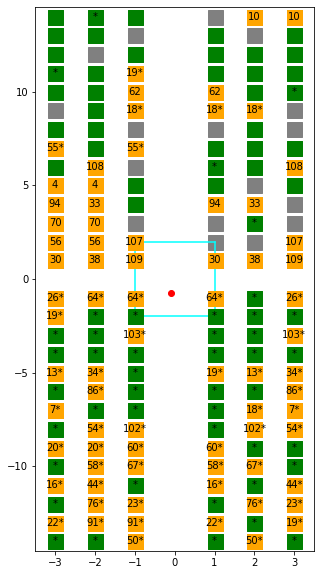

In [15]:
cm_x = round(barycenter_X.getValue(),2)
cm_y = round(barycenter_Y.getValue(),2)

print(f"Center of Mass: {(cm_x, cm_y)}")


fig = plt.figure(figsize=(5,10));
for seat in itertools.product(X,Y):
    if seat[0] != 0:
        plt.plot(seat[0],seat[1],'s', color="gray", markersize=15)

plt.plot([bary_lim_X, bary_lim_X]  , [-bary_lim_Y, bary_lim_Y],   color="cyan")
plt.plot([-bary_lim_X, -bary_lim_X], [-bary_lim_Y, bary_lim_Y],   color="cyan")
plt.plot([-bary_lim_X, bary_lim_X] , [bary_lim_Y, bary_lim_Y],    color="cyan")
plt.plot([-bary_lim_X, bary_lim_X] , [-bary_lim_Y, -bary_lim_Y],   color="cyan")

#for g in range(len(groups)):
    #print(j_g_max[g].x, j_g_min[g].x)

for a in allocation:
    if allocation[a].x == 1:
        label = ""
        if len(groups[passenger_from_id[a[0]].group_index].members) == 1:
            color = "green"
        else:
            color = "orange"
            label = label + str(passengers[a[0]].group_index)
            

        
        #plt.plot(X[a[1]],Y[a[2]], 'o',color=colors[passengers[a[0]].group_index-1])
        plt.plot(X[a[1]], Y[a[2]], 's', color=color, markersize=15)
        plt.text(X[a[1]], Y[a[2]],label+"*"*(passenger_from_id[a[0]].transit_time < 90), ha="center", va="center")
        print(f"Passenger ID:{a[0]} - Coordinate: {(a[1], a[2])}")
plt.plot(cm_x,cm_y, "o", color="red")
plt.ylim([-14.5,14.5])
plt.xlim([-3.5,3.5])